## Software empleado


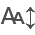

In [15]:
#
import os, sys
sys.path.append(os.path.abspath('notebooks/'))

#
import pandas as pd

#
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

# Código propio
from visual_utils import * 

#
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro, levene, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.multivariate.manova import MANOVA
from scikit_posthocs import posthoc_dunn

# PROBLEMA 1: ESTIMACIÓN DE EDAD

## 1.1. Carga de los resultados y obtención de métricas

In [16]:
# Carga de datos
df_AE_by_instance = pd.read_csv('results/AE_maxillofacial_test_results.csv')

display(df_AE_by_instance)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [17]:
# Nueva columna: error absoluto
df_AE_by_instance['absolute_error'] = (df_AE_by_instance['true_value'] - df_AE_by_instance['pred_point_value']).abs()

# Nueva columna: error cuadrático
df_AE_by_instance['squared_error'] = (df_AE_by_instance['true_value'] - df_AE_by_instance['pred_point_value']).pow(2)

# Nueva columna: tamaño del intervalo medio
df_AE_by_instance['pred_interval_width'] = df_AE_by_instance['pred_upper_bound'] - df_AE_by_instance['pred_lower_bound']

# Nueva columna: cobertura (true/false)
df_AE_by_instance['is_covered'] = (df_AE_by_instance['true_value'] >= df_AE_by_instance['pred_lower_bound']) & \
                          (df_AE_by_instance['true_value'] <= df_AE_by_instance['pred_upper_bound'])

# Nueva columna: interval score  
alpha = 1 - df_AE_by_instance['confidence']
df_AE_by_instance['interval_score'] = (
    (df_AE_by_instance['pred_upper_bound'] - df_AE_by_instance['pred_lower_bound']) 
    + (2 / alpha) * (df_AE_by_instance['pred_lower_bound'] - df_AE_by_instance['true_value']).clip(lower=0) 
    + (2 / alpha) * (df_AE_by_instance['true_value'] - df_AE_by_instance['pred_upper_bound']).clip(lower=0)
)

#
def sort_by_column(df, column, custom_order=None, secondary_column=None):
    if custom_order:
        df[column] = pd.Categorical(df[column], categories=custom_order, ordered=True)
    if secondary_column:
        return df.sort_values(by=[column, secondary_column])
    return df.sort_values(column)

# Ordena por iteración y por tipo de predicción
custom_order = ['base', 'ICP', 'QR', 'CQR']
df_AE_by_instance = sort_by_column(df_AE_by_instance, 'pred_model_type', custom_order, 
                                   secondary_column='iteration')

display(df_AE_by_instance)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [18]:
# Agrupar y calcular métricas
df_AE_by_run = (
    df_AE_by_instance
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .agg(
        mean_absolute_error=('absolute_error', 'mean'),
        mean_squared_error=('squared_error', 'mean'),
        empirical_coverage=('is_covered', 'mean'),
        mean_interval_width=('pred_interval_width', 'mean'),
        mean_interval_score=('interval_score', 'mean')
    )
    .reset_index()
)

df_AE_by_run = sort_by_column(df_AE_by_run, 'pred_model_type', custom_order, 
                              secondary_column='iteration')

display(df_AE_by_run)

/tmp/ipykernel_38826/2363473627.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'iteration'])


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## 1.2. Análisis de las métricas para la estimación puntual de edad

### Tabla resumen por método y ejecución

In [19]:
# Pivota para tener todas las métricas en columnas multi-nivel
pivot_point_metrics = df_AE_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['mean_absolute_error', 'mean_squared_error'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_point_metrics = pivot_point_metrics.swaplevel(axis=1).sort_index(axis=1)

In [20]:
# Calcular la media por método para cada métrica
pivot_point_with_mean = pd.concat([
    pivot_point_metrics,
    pivot_point_metrics.mean().to_frame().T.rename(index={0: 'Media'})
])

# Muestra con 2 decimales tanto MAE como MSE
styled_table = pivot_point_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza


VERIFICACIÓN DE SUPUESTOS PARA: MEAN_ABSOLUTE_ERROR

► Normalidad (Shapiro-Wilk): p = 0.5275
► Homocedasticidad (Levene): p = 0.8649
  - ✔ Normalidad aceptada
  - ✔ Homocedasticidad aceptada


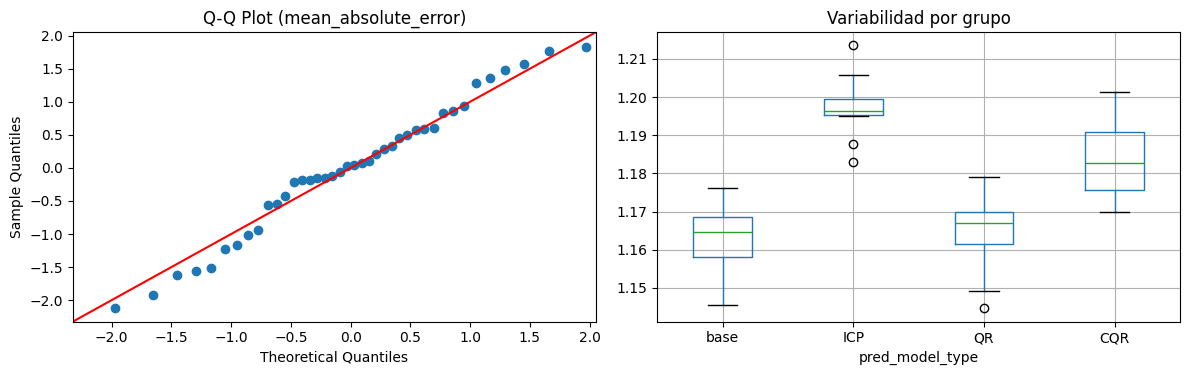


✅ Se cumplen los supuestos del ANOVA → Usar ANOVA + Tukey HSD

VERIFICACIÓN DE SUPUESTOS PARA: MEAN_SQUARED_ERROR

► Normalidad (Shapiro-Wilk): p = 0.5617
► Homocedasticidad (Levene): p = 0.7333
  - ✔ Normalidad aceptada
  - ✔ Homocedasticidad aceptada


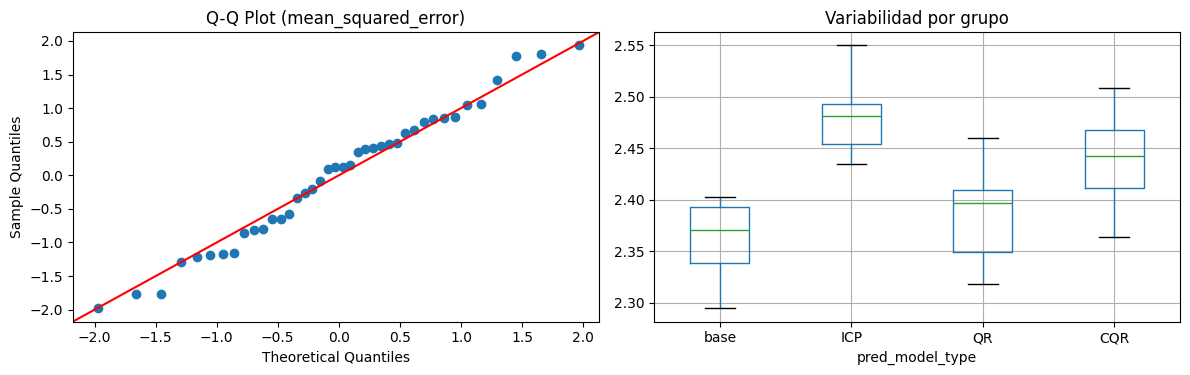


✅ Se cumplen los supuestos del ANOVA → Usar ANOVA + Tukey HSD


In [21]:
# 1. Verificación de supuestos para cada métrica
for metric in ['mean_absolute_error', 'mean_squared_error']:
    print(f"\n{'='*60}")
    print(f"VERIFICACIÓN DE SUPUESTOS PARA: {metric.upper()}")
    print(f"{'='*60}")
    
    # A. Preparar datos
    groups = [df_AE_by_run[df_AE_by_run['pred_model_type'] == method][metric] 
              for method in df_AE_by_run['pred_model_type'].unique()]
    
    # B. Normalidad (Shapiro-Wilk en residuos del ANOVA)
    model = ols(f'{metric} ~ C(pred_model_type)', data=df_AE_by_run).fit()
    _, p_normality = shapiro(model.resid)
    
    # C. Homocedasticidad (Levene)
    _, p_homogeneity = levene(*groups)
    
    # D. Mostrar resultados
    print(f"\n► Normalidad (Shapiro-Wilk): p = {p_normality:.4f}")
    print(f"► Homocedasticidad (Levene): p = {p_homogeneity:.4f}")
    
    # Interpretación
    assumptions_met = True
    if p_normality < 0.05:
        print("  - ✖ Violación de normalidad (usar Kruskal-Wallis)")
        assumptions_met = False
    else:
        print("  - ✔ Normalidad aceptada")
        
    if p_homogeneity < 0.05:
        print("  - ✖ Violación de homocedasticidad (usar Welch ANOVA o Kruskal-Wallis)")
        assumptions_met = False
    else:
        print("  - ✔ Homocedasticidad aceptada")
    
    # E. Gráficos diagnósticos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Gráfico Q-Q para normalidad
    sm.qqplot(model.resid, line='45', fit=True, ax=ax1)
    ax1.set_title(f'Q-Q Plot ({metric})')
    
    # Boxplot por grupo para homocedasticidad
    df_AE_by_run.boxplot(column=metric, by='pred_model_type', ax=ax2)
    ax2.set_title('Variabilidad por grupo')
    plt.suptitle('')
    plt.tight_layout()
    plt.show()
    
    # F. Recomendación final
    if assumptions_met:
        print("\n✅ Se cumplen los supuestos del ANOVA → Usar ANOVA + Tukey HSD")
    else:
        print("\n❌ No se cumplen los supuestos → Usar Kruskal-Wallis + Dunn")

In [22]:
def run_anova_tukey(df, metric, group_col='pred_model_type', alpha=0.05):
    """
    Ejecuta ANOVA + Tukey HSD y devuelve resultados formateados.
    
    Parámetros:
        df: DataFrame con los datos
        metric: Nombre de la columna métrica (ej: 'mean_absolute_error')
        group_col: Columna con los grupos/métodos a comparar
        alpha: Nivel de significancia
    """
    print(f"\n{'='*60}")
    print(f"ANÁLISIS ANOVA + TUKEY HSD PARA: {metric.upper()}")
    print(f"{'='*60}")
    
    # 1. Verificar supuestos
    print("\n🔍 VERIFICACIÓN DE SUPUESTOS:")
    
    # Normalidad (Shapiro-Wilk en residuos del ANOVA)
    model = ols(f'{metric} ~ C({group_col})', data=df).fit()
    _, p_normality = shapiro(model.resid)
    norm_ok = p_normality >= alpha
    
    # Homocedasticidad (Levene)
    groups = [df[df[group_col] == group][metric] 
              for group in df[group_col].unique()]
    _, p_homogeneity = levene(*groups)
    homog_ok = p_homogeneity >= alpha
    
    print(f"• Normalidad (Shapiro-Wilk): p = {p_normality:.4f} {'✅' if norm_ok else '❌'}")
    print(f"• Homocedasticidad (Levene): p = {p_homogeneity:.4f} {'✅' if homog_ok else '❌'}")
    
    if not (norm_ok and homog_ok):
        print("\n⚠️ ADVERTENCIA: No se cumplen los supuestos para ANOVA paramétrico.")
        print("   Considera usar Kruskal-Wallis + Dunn en su lugar.")
        return
    
    # 2. ANOVA
    print("\n📊 RESULTADOS ANOVA:")
    anova_table = sm.stats.anova_lm(model, typ=2)
    show(anova_table.style.format("{:.4f}"), allow_html=True)
    
    p_value = anova_table.loc[f'C({group_col})', 'PR(>F)']
    if p_value >= alpha:
        print(f"\nNo hay diferencias significativas entre grupos (p = {p_value:.4f} ≥ {alpha})")
        return
    
    # 3. Tukey HSD
    print(f"\n🔎 COMPARACIONES POR PARES (TUKEY HSD):")
    tukey = pairwise_tukeyhsd(
        endog=df[metric],
        groups=df[group_col],
        alpha=alpha
    )
    
    # Convertir resultados a DataFrame con formato
    tukey_df = pd.DataFrame(
        data=tukey._results_table.data[1:],
        columns=tukey._results_table.data[0]
    ).round(4)
    
    # Crear columna con intervalo de confianza formateado
    conf_pct = int((1 - alpha) * 100)
    tukey_df[f'IC ({conf_pct}%)'] = tukey_df.apply(
        lambda row: f"[{row['lower']}, {row['upper']}]",
        axis=1
    )

    # Eliminar columnas lower y upper
    tukey_df.drop(columns=['lower', 'upper'], inplace=True)
    
    show(tukey_df.style, allow_html=True)
    
    # # 4. Gráfico de comparaciones
    # print("\n📈 GRÁFICO DE INTERVALOS DE CONFIANZA:")
    # tukey.plot_simultaneous()
    # plt.xlabel('Diferencia en ' + metric)
    # plt.title('Comparación entre métodos (Tukey HSD)')
    # plt.show()

# Ejemplo de uso:
for metric in ['mean_absolute_error', 'mean_squared_error']:
    run_anova_tukey(df_AE_by_run, metric)


ANÁLISIS ANOVA + TUKEY HSD PARA: MEAN_ABSOLUTE_ERROR

🔍 VERIFICACIÓN DE SUPUESTOS:
• Normalidad (Shapiro-Wilk): p = 0.5275 ✅
• Homocedasticidad (Levene): p = 0.8649 ✅

📊 RESULTADOS ANOVA:


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



🔎 COMPARACIONES POR PARES (TUKEY HSD):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANÁLISIS ANOVA + TUKEY HSD PARA: MEAN_SQUARED_ERROR

🔍 VERIFICACIÓN DE SUPUESTOS:
• Normalidad (Shapiro-Wilk): p = 0.5617 ✅
• Homocedasticidad (Levene): p = 0.7333 ✅

📊 RESULTADOS ANOVA:


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



🔎 COMPARACIONES POR PARES (TUKEY HSD):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [23]:
def run_kruskal_dunn(df, metric, group_col='pred_model_type', alpha=0.05):
    """
    Ejecuta Kruskal-Wallis + Dunn y devuelve resultados formateados.
    
    Parámetros:
        df: DataFrame con los datos
        metric: Nombre de la columna métrica (ej: 'mean_absolute_error')
        group_col: Columna con los grupos/métodos a comparar
        alpha: Nivel de significancia
    """
    print(f"\n{'='*60}")
    print(f"ANÁLISIS NO PARAMÉTRICO PARA: {metric.upper()}")
    print(f"{'='*60}")
    
    # 1. Preparar datos
    groups = [df[df[group_col] == group][metric] 
              for group in df[group_col].unique()]
    group_names = df[group_col].unique()
    
    # 2. Kruskal-Wallis
    print("\n📊 TEST DE KRUSKAL-WALLIS:")
    h_stat, p_kruskal = kruskal(*groups)
    print(f"H-statistic = {h_stat:.4f}, p-value = {p_kruskal:.4f}")
    
    if p_kruskal >= alpha:
        print(f"\nNo hay diferencias significativas entre grupos (p = {p_kruskal:.4f} ≥ {alpha})")
        return
    
    # 3. Post-hoc Dunn
    print(f"\n🔎 COMPARACIONES POR PARES (DUNN):")
    dunn_results = posthoc_dunn(
        df, 
        val_col=metric, 
        group_col=group_col, 
        p_adjust='holm'  # Corrección para múltiples comparaciones
    )
    
    # Formatear resultados
    dunn_formatted = dunn_results.style.format("{:.4f}").set_caption(
        f"Valores p ajustados (Método: Holm) - α = {alpha}")
    
    show(dunn_formatted, allow_html=True)
    
    # # 4. Gráfico de visualización
    # print("\n📈 GRÁFICO DE DISTRIBUCIÓN POR MÉTODO:")
    # fig, ax = plt.subplots(figsize=(10, 6))
    # df.boxplot(column=metric, by=group_col, ax=ax)
    # plt.title('Distribución de ' + metric)
    # plt.suptitle('')
    # plt.xticks(rotation=45)
    # plt.show()

# Ejemplo de uso:
for metric in ['mean_absolute_error', 'mean_squared_error']:
    run_kruskal_dunn(df_AE_by_run, metric)


ANÁLISIS NO PARAMÉTRICO PARA: MEAN_ABSOLUTE_ERROR

📊 TEST DE KRUSKAL-WALLIS:
H-statistic = 28.2571, p-value = 0.0000

🔎 COMPARACIONES POR PARES (DUNN):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANÁLISIS NO PARAMÉTRICO PARA: MEAN_SQUARED_ERROR

📊 TEST DE KRUSKAL-WALLIS:
H-statistic = 23.8346, p-value = 0.0000

🔎 COMPARACIONES POR PARES (DUNN):


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## 1.3. Análisis de las métricas para la estimación interválica de edad

### Tabla resumen por método y ejecución

In [24]:
# Pivotea para tener todas las métricas en columnas multi-nivel
pivot_interval_metrics = df_AE_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['empirical_coverage', 'mean_interval_width', 'mean_interval_score'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_interval_metrics = pivot_interval_metrics.swaplevel(axis=1).sort_index(axis=1)

In [25]:
# Define el orden deseado de las métricas
metric_order = ['empirical_coverage', 'mean_interval_width', 'mean_interval_score'] 

# Reindexa las columnas según el orden especificado
pivot_interval_metrics = pivot_interval_metrics.reindex(columns=metric_order, level=0)

In [26]:
# Calcular la media por método para cada métrica
pivot_with_mean = pd.concat([
    pivot_interval_metrics,
    pivot_interval_metrics.mean().to_frame().T.rename(index={0: 'Media'})
])

# Multiplicar columnas de cobertura por 100
coverage_cols = [col for col in pivot_with_mean.columns if 'empirical_coverage' in str(col)]
pivot_with_mean[coverage_cols] = pivot_with_mean[coverage_cols] * 100

# Mostrar tabla con formato
styled_table = pivot_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza

In [29]:
# 1. Verificar normalidad multivariante (Mardia)
try:
    import pingouin as pg
    # Obtener ambos valores: estadístico y p-valor
    mardia_skew, mardia_kurtosis, p_value = pg.multivariate_normality(
        df_AE_by_run[['empirical_coverage', 'mean_interval_width']]
    )
    print(f"Normalidad multivariante (Mardia):\n - Sesgo: {mardia_skew:.4f}\n - Curtosis: {mardia_kurtosis:.4f}\n - p-valor: {p_value:.4f}")
except ImportError:
    print("Instala 'pingouin' para verificar normalidad multivariante: pip install pingouin")

# 2. Ejecutar MANOVA
manova = MANOVA.from_formula(
    formula='empirical_coverage + mean_interval_width ~ C(pred_model_type)',
    data=df_AE_by_run
)
print("\n📊 RESULTADOS MANOVA:")
print(manova.mv_test())

# 3. ANOVAs univariados post-MANOVA (para cada variable)
print("\n🔍 ANOVAS UNIVARIADOS:")
for metric in ['empirical_coverage', 'mean_interval_width']:
    print(f"\n► {metric.upper()}:")
    model = ols(f'{metric} ~ C(pred_model_type)', data=df_AE_by_run).fit()
    print(sm.stats.anova_lm(model, typ=2))

# 4. Comparaciones por pares (Tukey HSD para cada métrica)
print("\n🔎 COMPARACIONES POR PARES (TUKEY HSD):")
for metric in ['empirical_coverage', 'mean_interval_width']:
    print(f"\n• {metric.upper()}:")
    tukey = pairwise_tukeyhsd(
        endog=df_AE_by_run[metric],
        groups=df_AE_by_run['pred_model_type'],
        alpha=0.05
    )
    print(tukey.summary())

# # 5. Visualización (Boxplots multivariantes)
# plt.figure(figsize=(12, 6))
# sns.boxplot(
#     x='pred_model_type', 
#     y='value', 
#     hue='variable',
#     data=pd.melt(
#         df_AE_by_run, 
#         id_vars=['pred_model_type'], 
#         value_vars=['empirical_coverage', 'mean_interval_width']
#     )
# )
# plt.title("Comparación de cobertura empírica y ancho de intervalo por modelo")
# plt.ylabel("Valor")
# plt.xlabel("Modelo")
# plt.legend(title="Variable")
# plt.show()

Normalidad multivariante (Mardia):
 - Sesgo: 2.2874
 - Curtosis: 0.0000
 - p-valor: 0.0000

📊 RESULTADOS MANOVA:
                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
       Intercept          Value    Num DF  Den DF   F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda     0.0001 2.0000 35.0000 243525.2379 0.0000
         Pillai's trace     0.9999 2.0000 35.0000 243525.2379 0.0000
 Hotelling-Lawley trace 13915.7279 2.0000 35.0000 243525.2379 0.0000
    Roy's greatest root 13915.7279 2.0000 35.0000 243525.2379 0.0000
--------------------------------------------------------------------
                                                                    
--------------------------------------------------------------------
       C(pred_model_type)    Value   Num DF  Den DF  F Value  Pr > F
------------

### Gráfica de dispersión Cobertura empírica - Amplitud media del intervalo

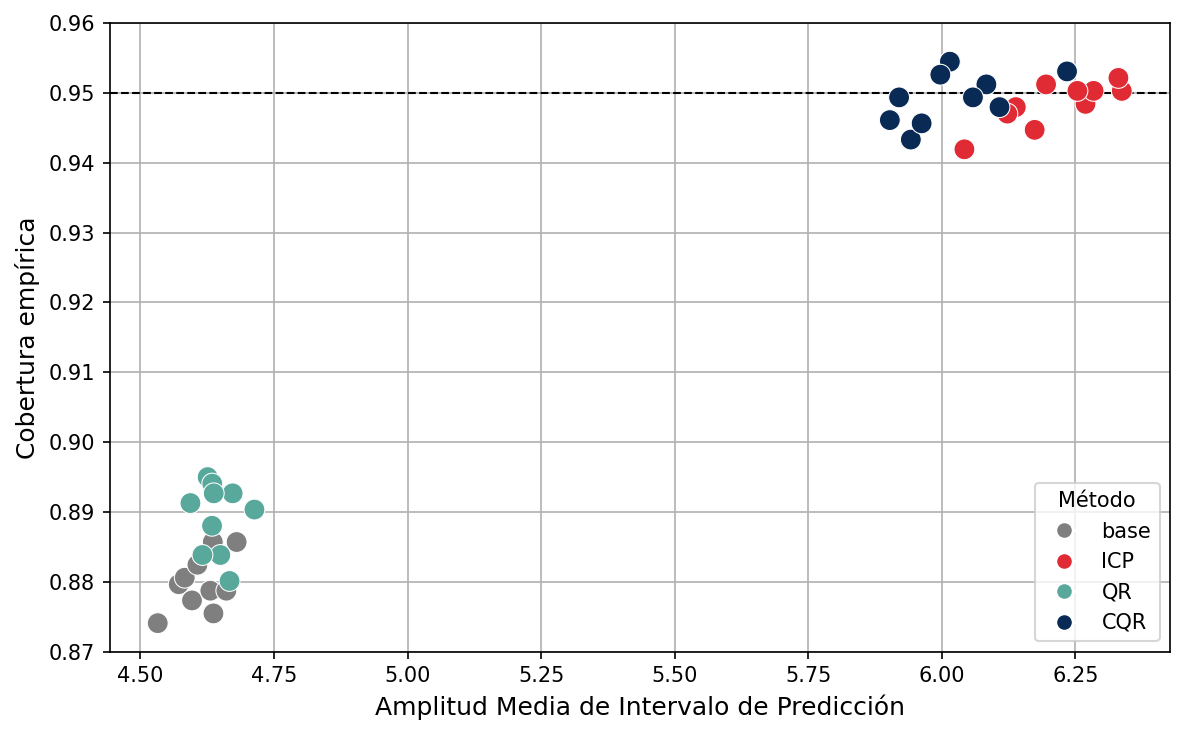

In [ ]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}
df_AE_by_run_to_plot = df_AE_by_run.copy()
df_AE_by_run_to_plot['color'] = df_AE_by_run_to_plot['pred_model_type'].map(color_dict)

#
plot_coverage_vs_interval_width(
    mean_pred_interval_widths = df_AE_by_run_to_plot['mean_interval_width'],
    empirical_coverages = df_AE_by_run_to_plot['empirical_coverage'],
    model_types = df_AE_by_run_to_plot['pred_model_type'],
    colors = df_AE_by_run_to_plot['color'],
    confidence_level = 0.95,
    figsize=(8,5),
    dpi=150
)

## 1.4. Análisis de la cobertura en base al tamaño del intervalo

### Histograma del ancho del intervalo con distinción de cobertura

In [30]:
# Añadir columna de ranking para 'mean_interval_score' dentro de cada grupo
df_AE_by_run = (
    df_AE_by_run
    .sort_values(['pred_model_type', 'confidence', 'mean_interval_width'])
    .assign(
        ranking_mean_interval_score=lambda x: x.groupby(['pred_model_type', 'confidence'])['mean_interval_score'].rank(method='dense')
    )
)

# Filtrar las mejores ejecuciones (ranking = 1)
best_runs = (
    df_AE_by_run[df_AE_by_run['ranking_mean_interval_score'] == 1]
    [['pred_model_type', 'confidence', 'iteration']]
)

# Unir con los datos originales para obtener solo la instancias de las mejores ejecuciones
df_best_AE_by_instance = pd.merge(
    df_AE_by_instance,
    best_runs,
    on=['pred_model_type', 'confidence', 'iteration'],
    how='inner'  # Solo conserva las coincidencias
)

display(df_best_AE_by_instance)

/tmp/ipykernel_38826/266897725.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ranking_mean_interval_score=lambda x: x.groupby(['pred_model_type', 'confidence'])['mean_interval_score'].rank(method='dense')


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


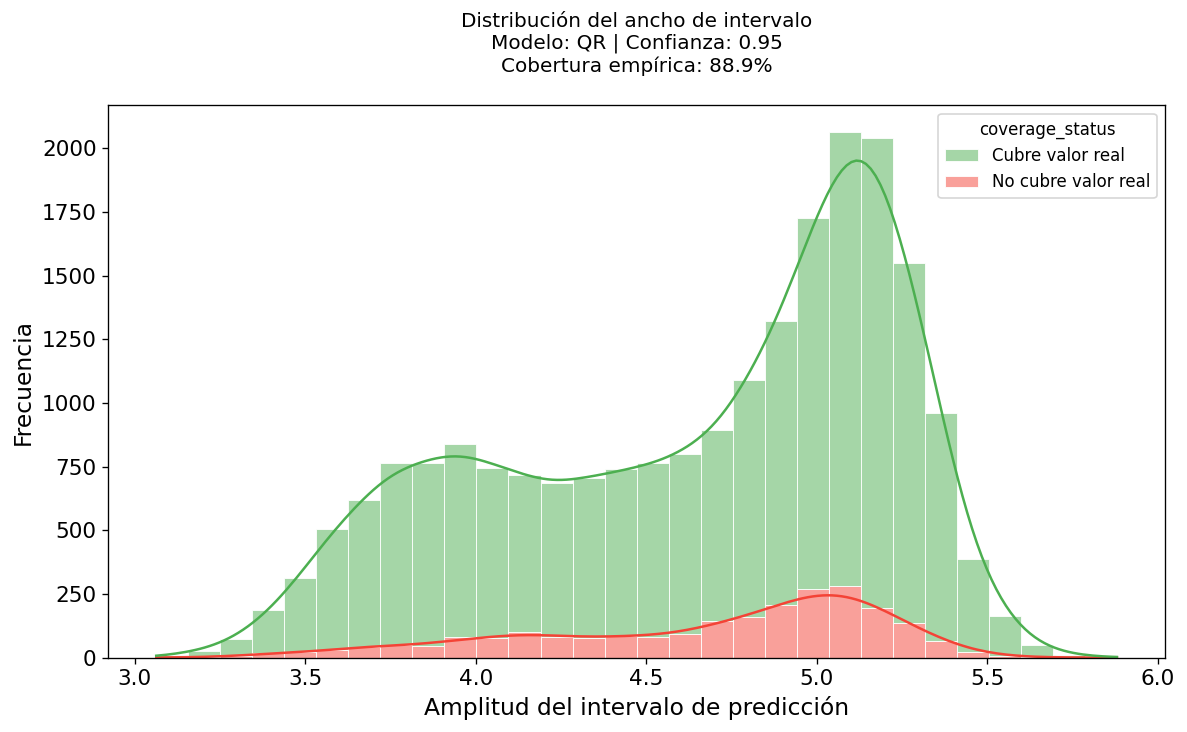

In [34]:
# Ejemplo de cómo usar la función
fig = plot_interval_width_histogram(df_AE_by_instance, pred_model_type='QR', confidence=0.95)
plt.show()

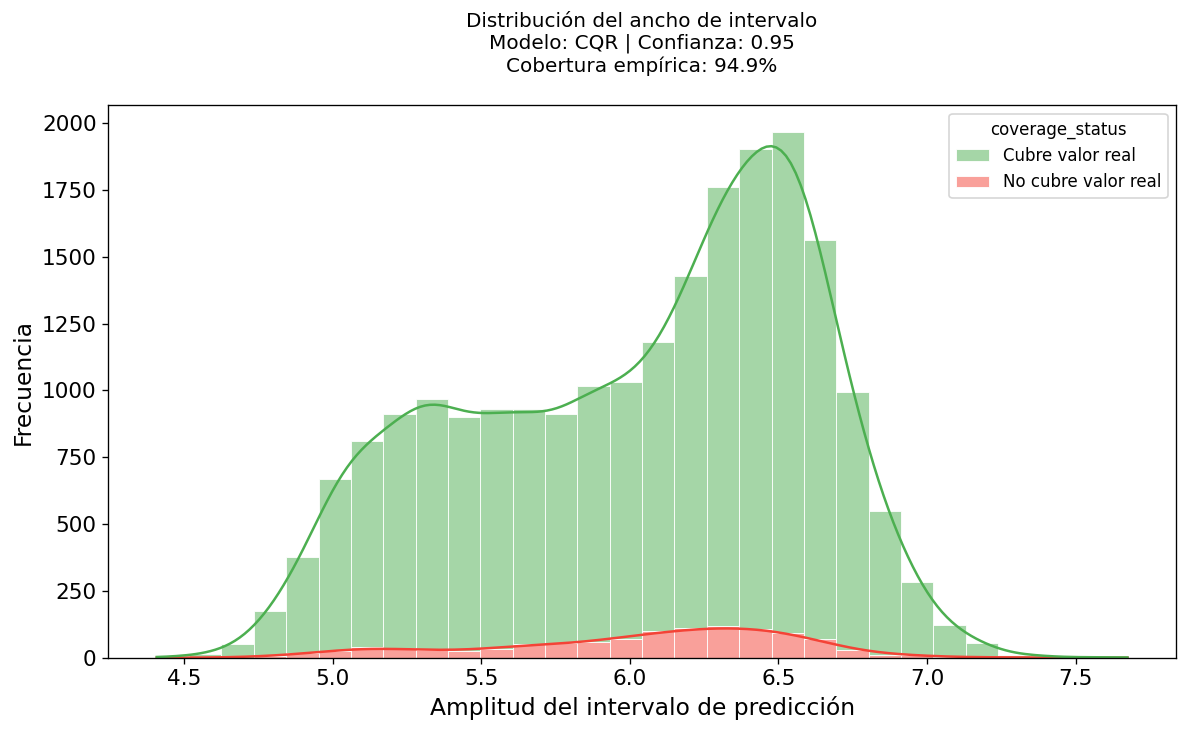

In [35]:
# Ejemplo de cómo usar la función
fig = plot_interval_width_histogram(df_AE_by_instance, pred_model_type='CQR', confidence=0.95)
plt.show()

### Tabla resumen de la cobertura por tamaño de intervalo para cada método

In [36]:
df_AE_by_instance_for_IW = df_AE_by_instance.copy()

# Define bins globales basados en el rango total de anchos de intervalo
max_width = df_AE_by_instance_for_IW['pred_interval_width'].max()
min_width = df_AE_by_instance_for_IW['pred_interval_width'].min()
bins = np.arange(0, np.ceil(max_width * 2)/2 + 0.5, 0.5)  # Desde 0 hasta max+0.5

# Asigna bins a cada instancia
df_AE_by_instance_for_IW['interval_width_bin'] = pd.cut(
    df_AE_by_instance_for_IW['pred_interval_width'],
    bins=bins,
    right=False,
    include_lowest=True
)

# Agrupa ...
df_AE_coverage_by_IW = df_AE_by_instance_for_IW.groupby(
    ['interval_width_bin', 'pred_model_type', 'confidence'],
    observed=True  # Forzar incluir todas las combinaciones
).agg(
    mean_coverage=('is_covered', 'mean'),
    min_width=('pred_interval_width', 'min'),
    count=('is_covered', 'count')
).reset_index()

# Define el orden deseado de los métodos
method_order = ['base', 'ICP', 'QR', 'CQR'] 
df_AE_coverage_by_IW['pred_model_type'] = pd.Categorical(
    df_AE_coverage_by_IW['pred_model_type'],
    categories=method_order,
    ordered=True
)

# Pivota ... 
pivot_result = df_AE_coverage_by_IW.pivot(
    index=['interval_width_bin'],
    columns=['pred_model_type', 'confidence'],
    values='mean_coverage'
).reindex(method_order, level=0, axis=1)

# 1. Multiplicar TODAS las columnas de cobertura por 100 (ya que todas contienen los valores de mean_coverage)
pivot_result = pivot_result * 100

# 2. Mostrar con formato de 2 decimales (sin %)
styled_table = pivot_result.style.format("{:.2f}")

# 3. Mostrar la tabla (en Jupyter/Colab)
show(styled_table,allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [50]:
df_AE_by_instance

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## 1.5. Análisis de la cobertura en base a la edad cronológica

### Tabla resumen por edad cronológica

In [72]:
df_AE_by_instance_for_age = df_AE_by_instance.copy()
df_AE_by_instance_for_age['true_value_int'] = df_AE_by_instance_for_age['true_value'].astype(int)

df_AE_by_true_age = (
    df_AE_by_instance_for_age
    .groupby(['pred_model_type', 'confidence','true_value_int'])
    .agg(
        empirical_coverage=('is_covered', 'mean'),
        mean_interval_width=('pred_interval_width', 'mean')
    )
    .reset_index()
)

# Pivota para tener todas las métricas en columnas multi-nivel
df_AE_by_true_age = df_AE_by_true_age.pivot(
    index='true_value_int',
    columns=['pred_model_type', 'confidence'],
    values=['empirical_coverage', 'mean_interval_width'] 
)

# Multiplica columnas de cobertura por 100
coverage_cols = [col for col in df_AE_by_true_age.columns if 'empirical_coverage' in str(col)]
df_AE_by_true_age[coverage_cols] = df_AE_by_true_age[coverage_cols] * 100

# Muestra tabla con formato
styled_table = df_AE_by_true_age.style.format("{:.2f}")
show(styled_table, allow_html=True)

/tmp/ipykernel_38826/452517760.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence','true_value_int'])


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Gráfica de ...

In [73]:
df_AE_coverage_by_age = df_AE_by_instance.copy()

#
df_AE_coverage_by_age['true_value_int'] = df_AE_coverage_by_age['true_value'].astype(int)

# Calcula la cobertura empírica por edad en entero
df_AE_coverage_by_age = df_AE_coverage_by_age.groupby(
    ['pred_model_type', 'confidence', 'true_value_int']
).agg(
    mean_coverage=('is_covered', 'mean'),  # % de cobertura empírica
    mean_interval_width=('pred_interval_width', 'mean'),  # Ancho promedio del intervalo en el decil
    mean_interval_score=('interval_score', 'mean'),
    count=('is_covered', 'count')  # Número de muestras en el decil
).reset_index()

df_AE_coverage_by_age['mean_coverage'] = (df_AE_coverage_by_age['mean_coverage'] * 100).round(2)
df_AE_coverage_by_age['mean_interval_width'] = df_AE_coverage_by_age['mean_interval_width'].round(2)
df_AE_coverage_by_age['mean_interval_score'] = df_AE_coverage_by_age['mean_interval_score'].round(2)

display(df_AE_coverage_by_age)

/tmp/ipykernel_38826/2010936644.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_AE_coverage_by_age = df_AE_coverage_by_age.groupby(


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


/tmp/ipykernel_38826/1803637119.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


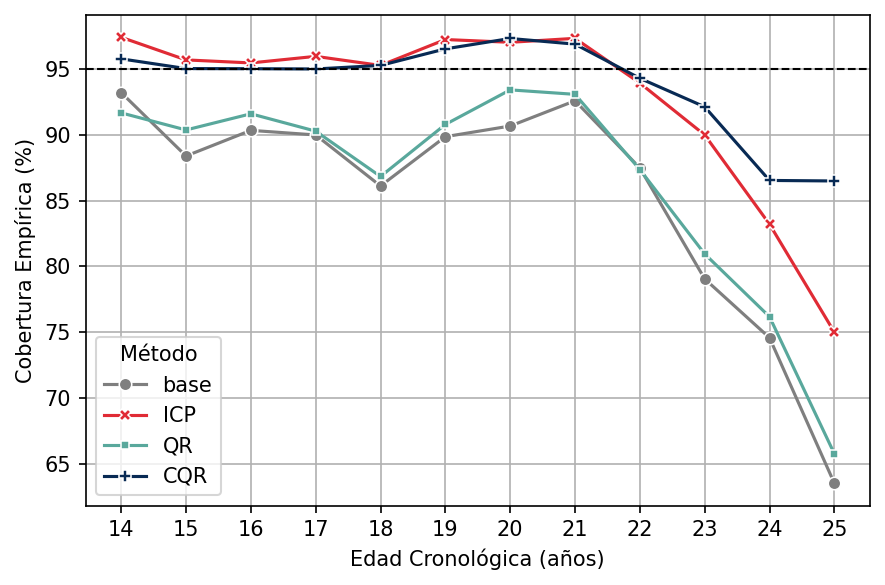

In [77]:
plt.figure(figsize=(6, 4), dpi=150)

color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}

sns.lineplot(
    data=df_AE_coverage_by_age,
    x='true_value_int',
    y='mean_coverage',
    hue='pred_model_type',
    style='pred_model_type',
    markers=True,
    dashes=False,
    palette=color_dict,
    ci=None  # si quieres puedes calcular intervalo de confianza, sino None para evitarlo
)

plt.xlabel('Edad Cronológica (años)')
plt.ylabel('Cobertura Empírica (%)')
plt.legend(title='Método')
plt.grid(True)

plt.xticks(range(df_AE_coverage_by_age['true_value_int'].min(),
                 df_AE_coverage_by_age['true_value_int'].max() + 1, 1))

plt.axhline(y=95, color='black', linestyle='--', linewidth=1.0, zorder=2)

plt.tight_layout()
plt.show()

/tmp/ipykernel_38826/2204689155.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


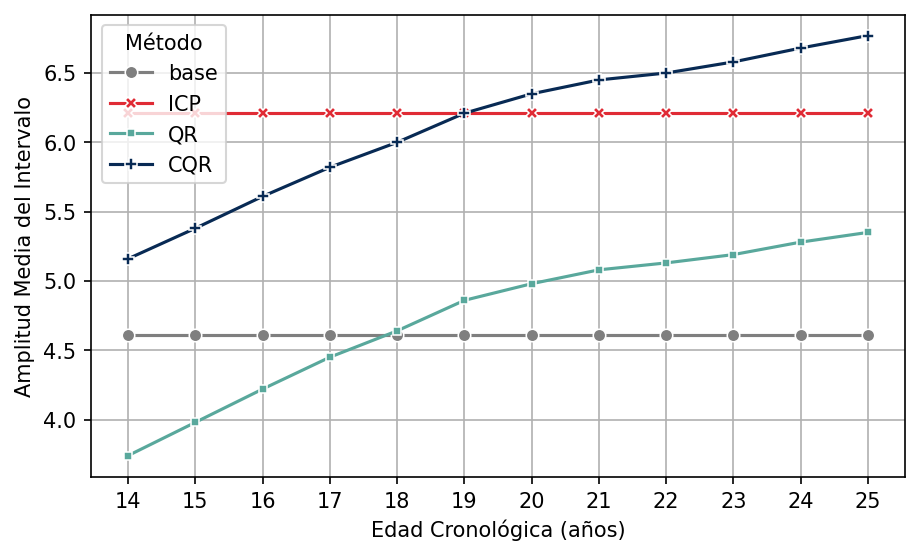

In [80]:
plt.figure(figsize=(7, 4), dpi=150)
sns.lineplot(
    data=df_AE_coverage_by_age,
    x='true_value_int',
    y='mean_interval_width',
    hue='pred_model_type',
    style='pred_model_type',
    markers=True,
    dashes=False,
    ci=None,
    palette=color_dict
)
plt.xlabel('Edad Cronológica (años)')
plt.ylabel('Amplitud Media del Intervalo')
plt.xticks(range(int(df_AE_coverage_by_age['true_value_int'].min()), 
                 int(df_AE_coverage_by_age['true_value_int'].max()) + 1, 1))

plt.legend(title='Método')
plt.grid(True)
plt.show()

### A

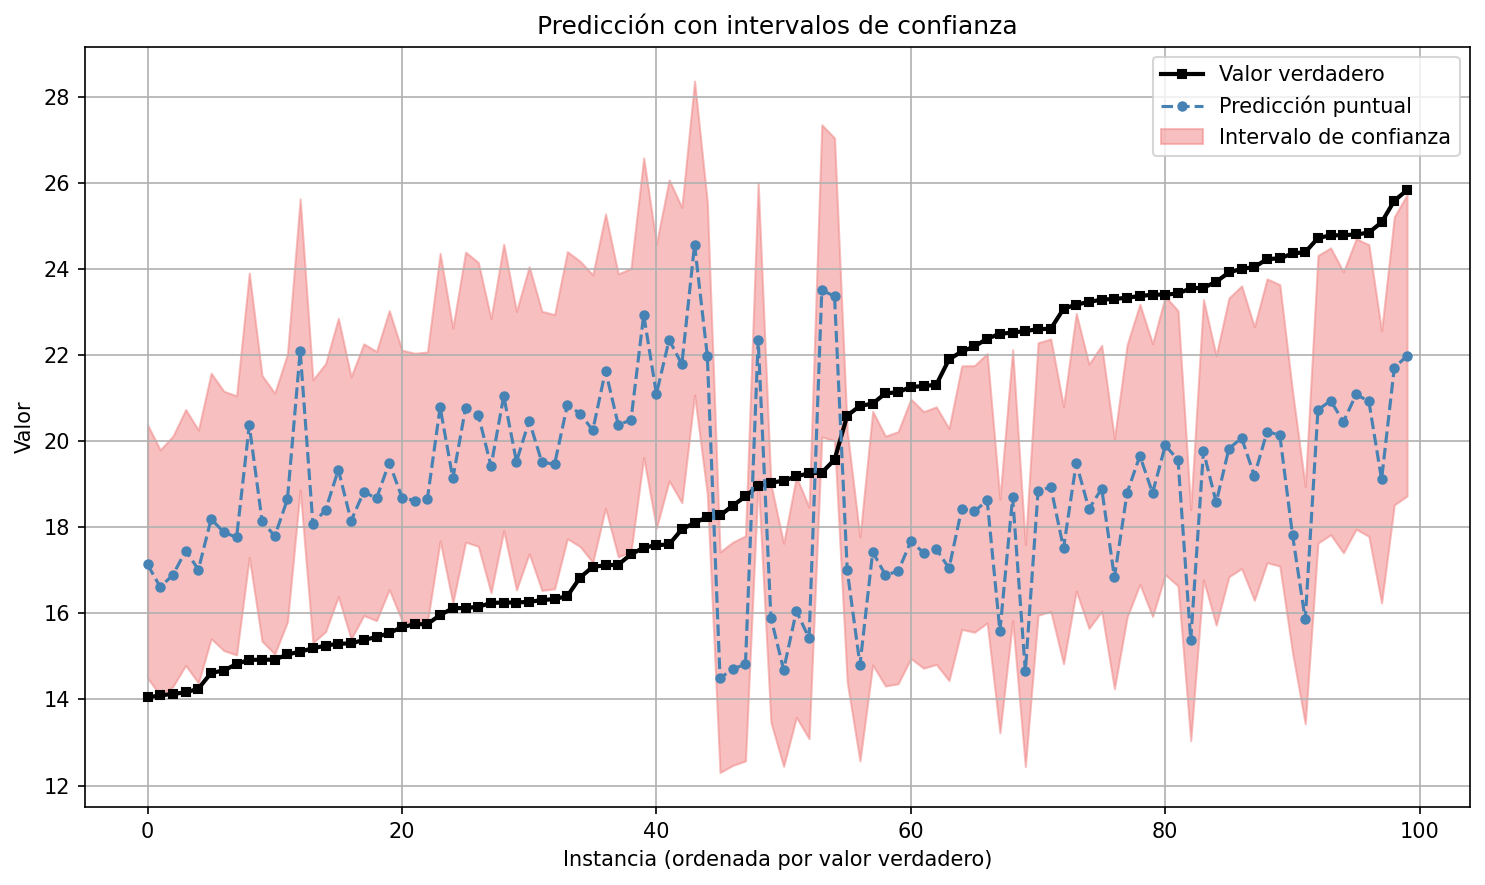

In [81]:
df_AE_by_instance_misclassified_CQR = (df_AE_by_instance[(df_AE_by_instance['pred_model_type'] == 'CQR') &
                                                         (df_AE_by_instance['is_covered'] == False)])

n = 100

# Extraer los valores y convertir a tensores
pred_point_values = torch.tensor(df_AE_by_instance_misclassified_CQR['pred_point_value'].values[0:n])
pred_lower_bound = torch.tensor(df_AE_by_instance_misclassified_CQR['pred_lower_bound'].values[0:n])
pred_upper_bound = torch.tensor(df_AE_by_instance_misclassified_CQR['pred_upper_bound'].values[0:n])
true_values = torch.tensor(df_AE_by_instance_misclassified_CQR['true_value'].values[0:n])

# Llamar a la función de plot
plot_interval_predictions(
    pred_point_values=pred_point_values,
    pred_lower_bound=pred_lower_bound,
    pred_upper_bound=pred_upper_bound,
    true_values=true_values
)

# PROBLEMA 2: CLASIFICACIÓN DE MAYORÍA DE EDAD

## 2.1. Carga de resultados y obtención de métricas

In [82]:
# Carga de datos
df_AMC_by_instance = pd.read_csv('results/AMM_maxillofacial_test_results.csv')

display(df_AMC_by_instance)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [83]:
# Nueva columna: verdaderos positivos
df_AMC_by_instance['TP'] = (df_AMC_by_instance['pred_class'] == 1) & (df_AMC_by_instance['true_class'] == 1)

# Nueva columna: verdaderos negativos
df_AMC_by_instance['TN'] = (df_AMC_by_instance['pred_class'] == 0) & (df_AMC_by_instance['true_class'] == 0)

# falsos positivos
df_AMC_by_instance['FP'] = (df_AMC_by_instance['pred_class'] == 1) & (df_AMC_by_instance['true_class'] == 0)

# Nueva columna: falsos negativos
df_AMC_by_instance['FN'] = (df_AMC_by_instance['pred_class'] == 0) & (df_AMC_by_instance['true_class'] == 1)

# Nueva columna: cobertura (true/false)
df_AMC_by_instance['is_covered'] = ((df_AMC_by_instance['true_class'] == 0) & (df_AMC_by_instance['pred_set_under_18'] == 1)) | \
                          ((df_AMC_by_instance['true_class'] == 1) & (df_AMC_by_instance['pred_set_over_18'] == 1))
                          
# Nueva columna: tamaño del conjunto de predicción
df_AMC_by_instance['pred_set_size'] = df_AMC_by_instance['pred_set_under_18'] + df_AMC_by_instance['pred_set_over_18']

# Nueva columna: set score
alpha = 1 - df_AMC_by_instance['confidence']
df_AMC_by_instance['set_score'] = df_AMC_by_instance['pred_set_size'] + 1/alpha * (~df_AMC_by_instance['is_covered'])

# Ordenar por iteración y por tipo de predicción
custom_order = ['base', 'LAC', 'MCM']
df_AMC_by_instance = sort_by_column(df_AMC_by_instance, 'pred_model_type', custom_order, 
                                      secondary_column='iteration')

display(df_AMC_by_instance)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [84]:
# Agrupar y calcular métricas
df_AMC_by_run = (
    df_AMC_by_instance
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': (g['TP'].sum() + g['TN'].sum()) / len(g),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean()
    }))
    .reset_index()
)

# Ordenar por iteración y por tipo de predicción
custom_order = ['base', 'LAC', 'MCM']
df_AMC_by_run = sort_by_column(df_AMC_by_run, 'pred_model_type', custom_order, secondary_column='iteration')

display(df_AMC_by_run)

/tmp/ipykernel_38826/2627652843.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'iteration'])
/tmp/ipykernel_38826/2627652843.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## 2.2. Análisis de las métricas para la clasificación puntual de mayoría de edad

### Tabla resumen por método y ejecución

In [85]:
# Pivota para tener todas las métricas en columnas multi-nivel
pivot_point_metrics = df_AMC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['accuracy'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_point_metrics = pivot_point_metrics.swaplevel(axis=1).sort_index(axis=1)

In [87]:
# Multiplica todos los valores por 100
pivot_point_metrics_100 = pivot_point_metrics * 100

# Calcular la media por método para cada métrica
pivot_point_with_mean = pd.concat([
    pivot_point_metrics_100,
    pivot_point_metrics_100.mean().to_frame().T.rename(index={0: 'Media'})
])

# Muestra con 2 decimales tanto MAE como MSE
styled_table = pivot_point_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza

## 2.3. Análisis de las métricas para la clasificación de mayoría de edad en conjunto de predicción 


### Tabla resumen por método y ejecución

In [88]:
# Pivotea para tener todas las métricas en columnas multi-nivel
pivot_interval_metrics = df_AMC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['empirical_coverage', 'mean_set_size', 'mean_set_score'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_interval_metrics = pivot_interval_metrics.swaplevel(axis=1).sort_index(axis=1)

In [89]:
# Define el orden deseado de las métricas
metric_order = ['empirical_coverage', 'mean_set_size', 'mean_set_score'] 

# Reindexa las columnas según el orden especificado
pivot_interval_metrics = pivot_interval_metrics.reindex(columns=metric_order, level=0)

In [90]:
# Calcular la media por método para cada métrica
pivot_with_mean = pd.concat([
    pivot_interval_metrics,
    pivot_interval_metrics.mean().to_frame().T.rename(index={0: 'Media'})
])

# Multiplicar columnas de cobertura por 100
coverage_cols = [col for col in pivot_with_mean.columns if 'empirical_coverage' in str(col)]
pivot_with_mean[coverage_cols] = pivot_with_mean[coverage_cols] * 100

# Mostrar tabla con formato
styled_table = pivot_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza

### Gráfica de dispersión Cobertura empírica - Amplitud media del intervalo

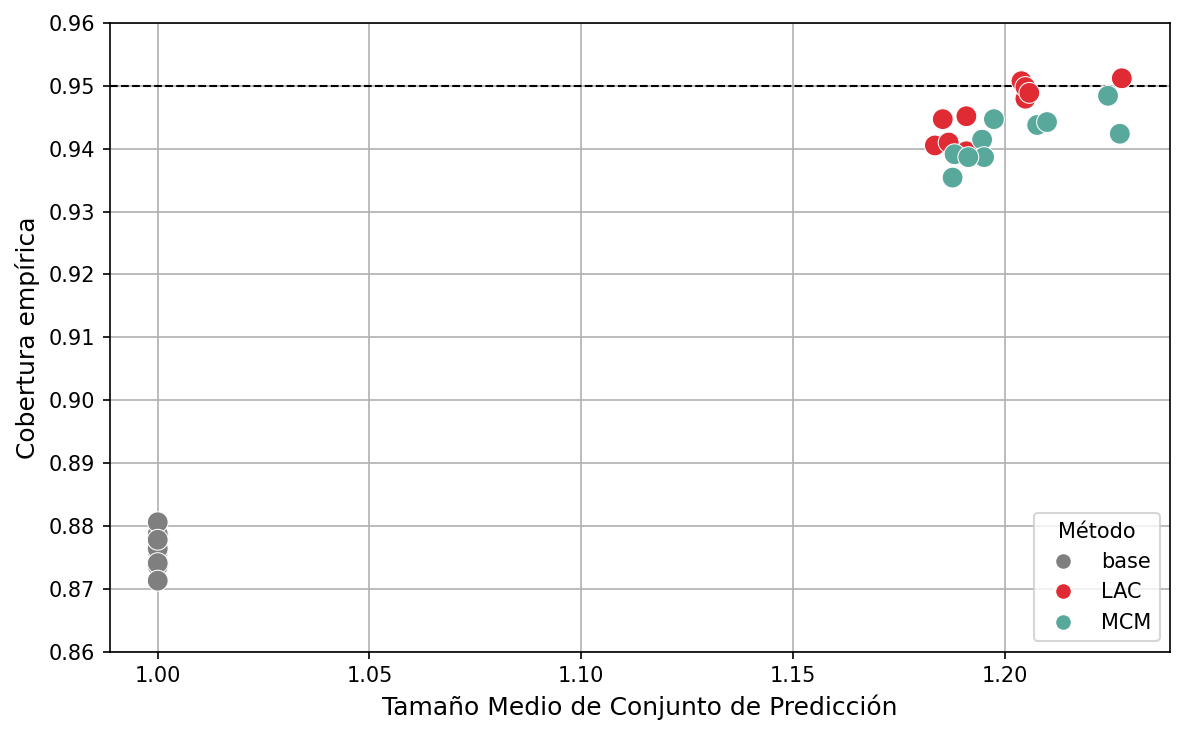

In [91]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'LAC': '#e02b35', 'MCM': '#59a89c'}
df_AMC_by_run_to_plot = df_AMC_by_run.copy()
df_AMC_by_run_to_plot['color'] = df_AMC_by_run_to_plot['pred_model_type'].map(color_dict)

#
plot_coverage_vs_set_size(
    mean_set_sizes=df_AMC_by_run_to_plot['mean_set_size'],
    empirical_coverages=df_AMC_by_run_to_plot['empirical_coverage'],
    model_types=df_AMC_by_run_to_plot['pred_model_type'],
    colors=df_AMC_by_run_to_plot['color'],
    confidence_level=0.95,
    figsize=(8, 5),
    dpi=150
)

## 2.4. Análisis de la cobertura en base a la clase

### Matriz de confusión conformal

In [92]:
# Añadir columna de ranking para 'mean_set_score' dentro de cada grupo
df_AMC_by_run = (
    df_AMC_by_run
    .sort_values(['pred_model_type', 'confidence', 'mean_set_size'])
    .assign(
        ranking_mean_set_score=lambda x: x.groupby(['pred_model_type', 'confidence'])['mean_set_score']
                                             .rank(method='dense')
    )
)

# Filtrar las mejores ejecuciones (ranking = 1)
best_runs = (
    df_AMC_by_run[df_AMC_by_run['ranking_mean_set_score'] == 1]
    [['pred_model_type', 'confidence', 'iteration']]
)

# Unir con los datos originales para obtener solo la instancias de las mejores ejecuciones
df_best_AMC_by_instance = pd.merge(
    df_AMC_by_instance,
    best_runs,
    on=['pred_model_type', 'confidence', 'iteration'],
    how='inner'  # Solo conserva las coincidencias
)

display(df_best_AMC_by_instance)

/tmp/ipykernel_38826/3901617541.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ranking_mean_set_score=lambda x: x.groupby(['pred_model_type', 'confidence'])['mean_set_score']


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


/tmp/ipykernel_38826/3214355747.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'true_class', 'pred_set_label'])
/tmp/ipykernel_38826/3214355747.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence'])['is_covered']
/tmp/ipykernel_38826/3214355747.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (model, conf), group in confusi

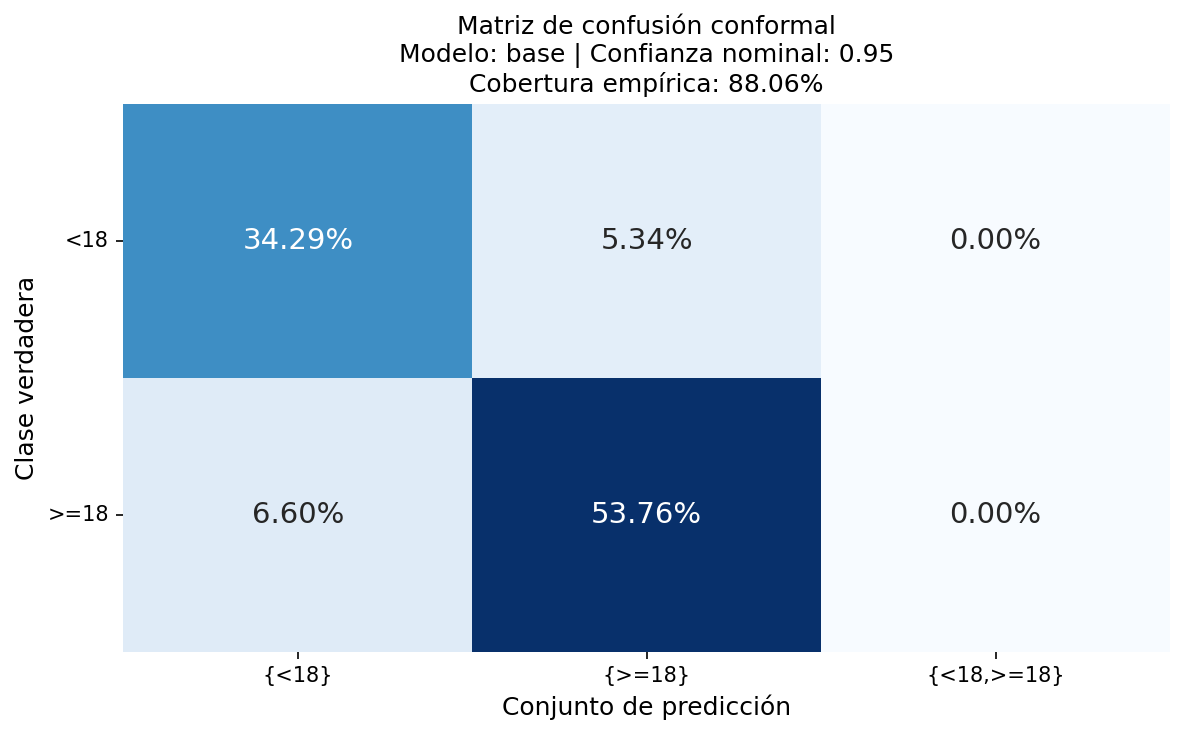

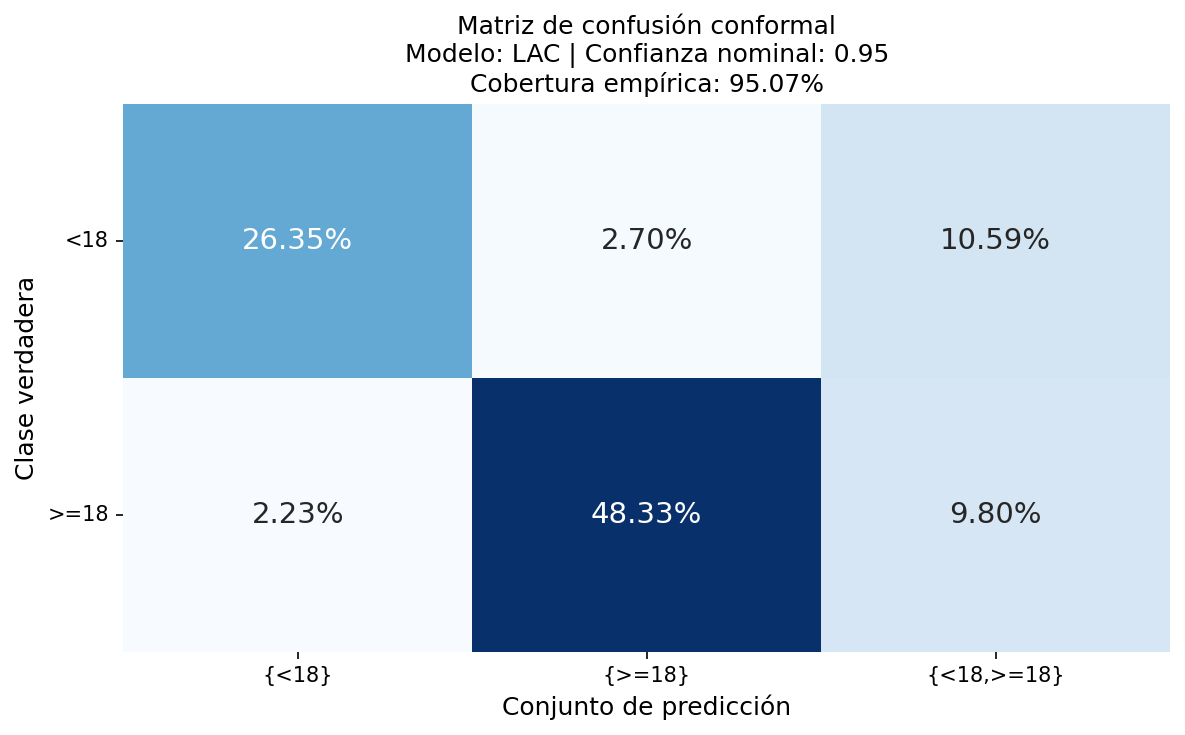

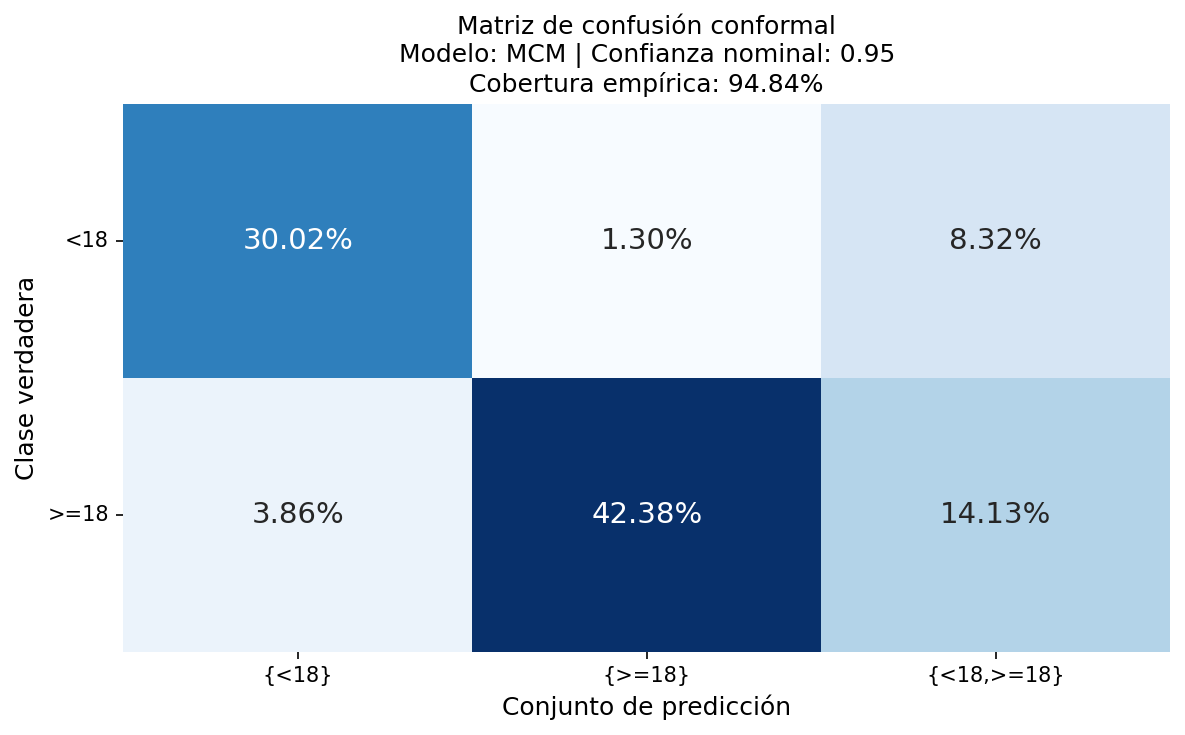

In [95]:
def pred_set_label(row):
    if row['pred_set_under_18'] == 1 and row['pred_set_over_18'] == 0:
        return '{<18}'
    elif row['pred_set_under_18'] == 0 and row['pred_set_over_18'] == 1:
        return '{>=18}'
    elif row['pred_set_under_18'] == 1 and row['pred_set_over_18'] == 1:
        return '{<18,>=18}'
    else:
        return '∅'  # Por si acaso, aunque dices que nunca ocurre

df_best_AMC_by_instance['pred_set_label'] = df_best_AMC_by_instance.apply(pred_set_label, axis=1)

confusion_conformal = (
    df_best_AMC_by_instance
    .groupby(['pred_model_type', 'confidence', 'true_class', 'pred_set_label'])
    .size()
    .reset_index(name='count')
)

empirical_coverage_by_group = (
    df_best_AMC_by_instance
    .groupby(['pred_model_type', 'confidence'])['is_covered']
    .mean()
    .reset_index(name='empirical_coverage')
)

coverage_dict = {
    (row['pred_model_type'], row['confidence']): row['empirical_coverage']
    for _, row in empirical_coverage_by_group.iterrows()
}

# Posibles etiquetas de columnas en orden
pred_set_labels = ['{<18}', '{>=18}', '{<18,>=18}']

# Dibujar una matriz por cada combinación
for (model, conf), group in confusion_conformal.groupby(['pred_model_type', 'confidence']):
    # Crear tabla cruzada (confusion matrix)
    pivot = group.pivot(index='true_class', columns='pred_set_label', values='count').fillna(0)

    # Asegurar columnas en orden
    for label in pred_set_labels:
        if label not in pivot.columns:
            pivot[label] = 0
    pivot = pivot[pred_set_labels]
    
    # Normalizar: dividir entre el total de instancias del grupo
    total = pivot.values.sum()
    pivot_normalized = pivot / total if total > 0 else pivot  # evitar división por cero

    # Obtener cobertura
    coverage = coverage_dict.get((model, conf), None)
    coverage_str = f'{coverage:.2%}' if coverage is not None else 'N/A'

    # Plot
    plt.figure(figsize=(8, 5), dpi=150)
    sns.heatmap(pivot_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False, annot_kws={"size": 14})
    plt.title(f'Matriz de confusión conformal\nModelo: {model} | Confianza nominal: {conf}\n' + 
              f'Cobertura empírica: {coverage_str}')
    plt.xlabel('Conjunto de predicción', fontsize=12)
    plt.ylabel('Clase verdadera', fontsize=12)
    plt.yticks([0.5, 1.5], ['<18', '>=18'], rotation=0)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_38826/4122332324.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (model, conf), group in confusion_conformal.groupby(['pred_model_type', 'confidence']):


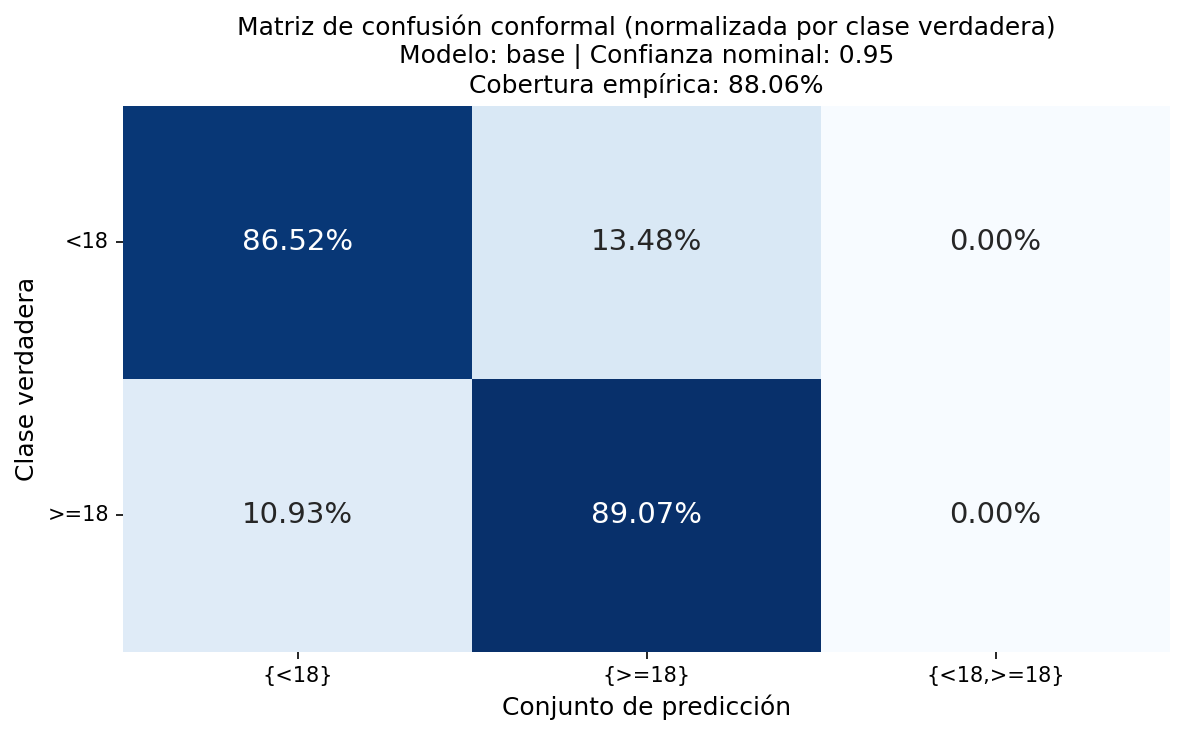

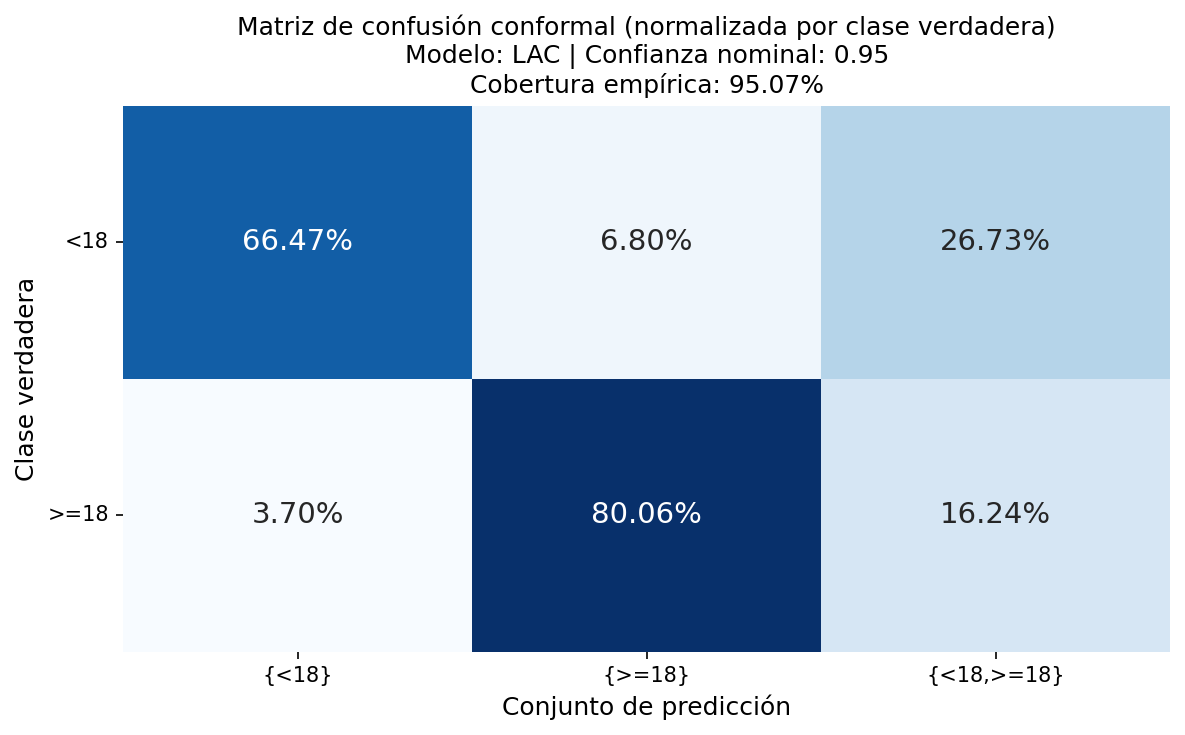

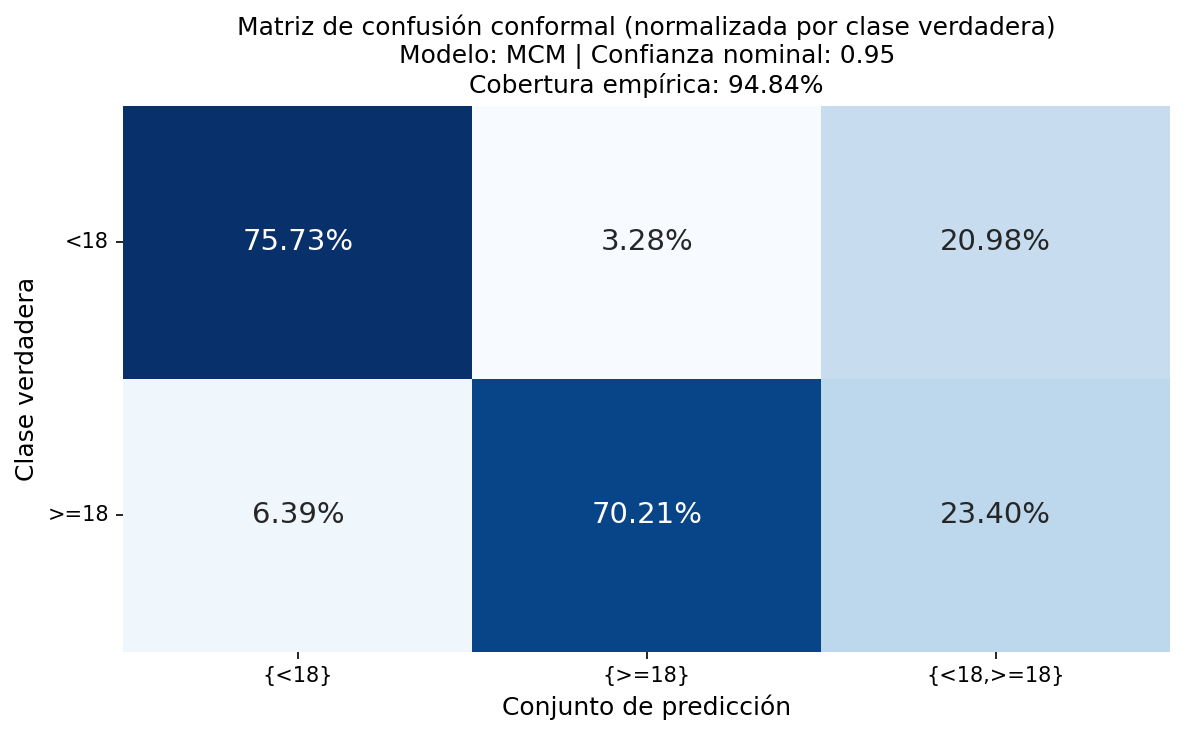

In [96]:
# Dibujar una matriz por cada combinación
for (model, conf), group in confusion_conformal.groupby(['pred_model_type', 'confidence']):
    # Crear tabla cruzada (confusion matrix)
    pivot = group.pivot(index='true_class', columns='pred_set_label', values='count').fillna(0)

    # Asegurar columnas en orden
    for label in pred_set_labels:
        if label not in pivot.columns:
            pivot[label] = 0
    pivot = pivot[pred_set_labels]

    # Normalizar por clase verdadera (por fila)
    pivot_normalized = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)

    # Obtener cobertura
    coverage = coverage_dict.get((model, conf), None)
    coverage_str = f'{coverage:.2%}' if coverage is not None else 'N/A'

    # Plot
    plt.figure(figsize=(8, 5), dpi=150)
    sns.heatmap(pivot_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False, annot_kws={"size": 14})
    plt.title(f'Matriz de confusión conformal (normalizada por clase verdadera)\nModelo: {model} | Confianza nominal: {conf}\n' +
              f'Cobertura empírica: {coverage_str}')
    plt.xlabel('Conjunto de predicción', fontsize=12)
    plt.ylabel('Clase verdadera', fontsize=12)
    plt.yticks([0.5, 1.5], ['<18', '>=18'], rotation=0)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


# PROBLEMA 3: ESTIMACIÓN DE CLASIFICACIÓN EN SEXO Y MAYORÍA DE EDAD

## 3.1. Carga de datos

In [102]:
# Carga de datos
df_AMSC_by_instance = pd.read_csv('results/AMSC_maxillofacial_test_results.csv')

display(df_AMSC_by_instance)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [103]:
# Nueva columna: cobertura (true/false)
df_AMSC_by_instance['well_classified'] = (df_AMSC_by_instance['true_class'] == df_AMSC_by_instance['pred_class'])

# Nueva columna: cobertura (true/false)
df_AMSC_by_instance['is_covered'] = (
    ((df_AMSC_by_instance['true_class'] == 0) & (df_AMSC_by_instance['pred_set_male_under_18'] == 1)) |
    ((df_AMSC_by_instance['true_class'] == 1) & (df_AMSC_by_instance['pred_set_male_over_18'] == 1)) |
    ((df_AMSC_by_instance['true_class'] == 2) & (df_AMSC_by_instance['pred_set_female_under_18'] == 1)) |
    ((df_AMSC_by_instance['true_class'] == 3) & (df_AMSC_by_instance['pred_set_female_over_18'] == 1))
)

# Nueva columna: tamaño del conjunto de predicción
df_AMSC_by_instance['pred_set_size'] = (
    df_AMSC_by_instance['pred_set_male_under_18'] + df_AMSC_by_instance['pred_set_male_over_18'] + 
    df_AMSC_by_instance['pred_set_female_under_18'] + df_AMSC_by_instance['pred_set_female_over_18']
)

# Nueva columna: set score
alpha = 1 - df_AMSC_by_instance['confidence']
df_AMSC_by_instance['set_score'] = (df_AMSC_by_instance['pred_set_size'] +
                                    1/alpha * (~df_AMSC_by_instance['is_covered']))

# Ordenar por iteración y por tipo de predicción
custom_order = ['base', 'LAC', 'MCM', 'APS', 'RAPS']
df_AMSC_by_intance = sort_by_column(df_AMSC_by_instance, 'pred_model_type', custom_order, 
                                    secondary_column='iteration')

display(df_AMSC_by_instance)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [104]:
# Agrupar y calcular métricas
df_AMSC_by_run = (
    df_AMSC_by_instance
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': g['well_classified'].mean(),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean()
    }))
    .reset_index()
)

display(df_AMSC_by_run)

/tmp/ipykernel_38826/1060119993.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'iteration'])
/tmp/ipykernel_38826/1060119993.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


ValueError: cannot insert iteration, already exists

## 3.2. Análisis de las métricas para la clasificación puntual de mayoría de edad y sexo

### Tabla resumen por método y ejecución

In [100]:
# Pivota para tener todas las métricas en columnas multi-nivel
pivot_point_metrics = df_AMSC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['accuracy'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_point_metrics = pivot_point_metrics.swaplevel(axis=1).sort_index(axis=1)

In [101]:
# Calcular la media por método para cada métrica
pivot_point_with_mean = pd.concat([
    pivot_point_metrics,
    pivot_point_metrics.mean().to_frame().T.rename(index={0: 'Media'})
])

# Muestra con 2 decimales tanto MAE como MSE
styled_table = pivot_point_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza

## 3.3. Análisis de las métricas para la clasificación de mayoría de sexo y edad en conjunto de predicción

### Tabla resumen por método y ejecución

In [40]:
# Pivotea para tener todas las métricas en columnas multi-nivel
pivot_interval_metrics = df_AMSC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['empirical_coverage', 'mean_set_size', 'mean_set_score'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_interval_metrics = pivot_interval_metrics.swaplevel(axis=1).sort_index(axis=1)

In [41]:
# Define el orden deseado de las métricas
metric_order = ['empirical_coverage', 'mean_set_size', 'mean_set_score'] 

# Reindexa las columnas según el orden especificado
pivot_interval_metrics = pivot_interval_metrics.reindex(columns=metric_order, level=0)

In [42]:
# Calcular la media por método para cada métrica
pivot_with_mean = pd.concat([
    pivot_interval_metrics,
    pivot_interval_metrics.mean().to_frame().T.rename(index={0: 'Media'})
])

# Multiplicar columnas de cobertura por 100
coverage_cols = [col for col in pivot_with_mean.columns if 'empirical_coverage' in str(col)]
pivot_with_mean[coverage_cols] = pivot_with_mean[coverage_cols] * 100

# Mostrar tabla con formato
styled_table = pivot_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Análisis de la varianza

### Gráfica de dispersión Cobertura empírica - Amplitud media del intervalo

## 3.4. Análisis de la cobertura por tamaño del conjunto de predicción

###  Tabla resumen de la cobertura por tamaño de intervalo para cada método

## 3.5. Análisis de la cobertura por clase

### Diagrama de Venn para conjuntos de predicciones